# SESSION 7 : Chains in LangChain | Generative AI using LangChain | Video 7

https://youtu.be/5hjrPILA3-8?list=PLKnIA16_RmvaTbihpo4MtzVm4XOQa0ER0

**Chains** are the **core abstraction** in LangChain, and understanding them makes it way easier to build real-world apps with LLMs.


* A **Chain** is a sequence of steps (or components) where the **output of one step becomes the input of the next**.


* They connect LLMs, prompts, parsers, retrievers, tools, etc.


* Instead of writing ad-hoc glue code, LangChain gives reusable **chain classes**.

👉 Think of chains as **pipelines for LLM workflows**.

## 🔹 Types of Chains in LangChain

There are multiple built-in types. Let’s cover the main ones:

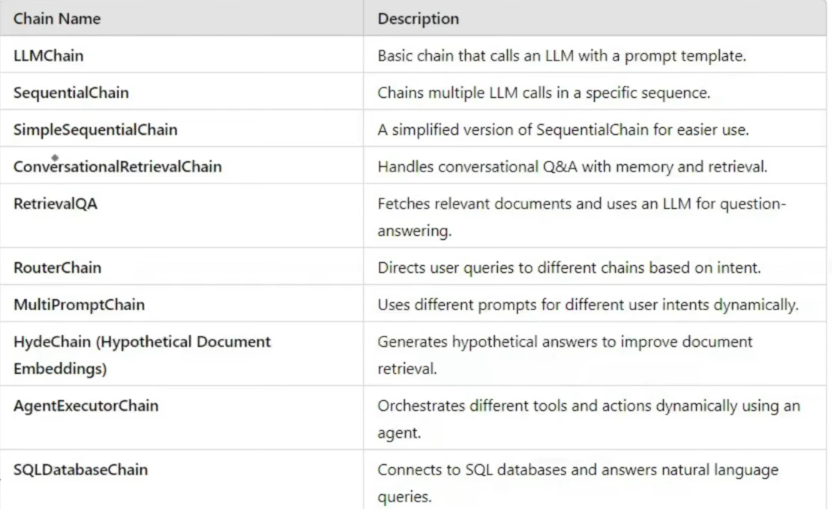

### 1. **LLMChain**

* Simplest chain: **PromptTemplate → LLM → Output**.

* Used for text generation or simple Q\&A.

```python
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain

llm = ChatOpenAI(model="gpt-4o-mini")
prompt = PromptTemplate.from_template("Translate this to French: {text}")

chain = LLMChain(llm=llm, prompt=prompt)

print(chain.run("I love programming"))
# → "J'adore la programmation"
```

✅ Use when you just need one prompt + one LLM call.

### 2. **SimpleSequentialChain**

* Runs multiple chains **sequentially**.
* Each chain’s output becomes the next chain’s input.

```python
from langchain.chains import SimpleSequentialChain

chain1 = LLMChain(llm=llm, prompt=PromptTemplate.from_template("Summarize: {text}"))
chain2 = LLMChain(llm=llm, prompt=PromptTemplate.from_template("Translate to Spanish: {text}"))

overall_chain = SimpleSequentialChain(chains=[chain1, chain2])

print(overall_chain.run("LangChain makes building LLM apps easy."))
# → "LangChain facilita la creación de aplicaciones LLM."
```

✅ Use when you have a **linear pipeline** of tasks.

### 3. **SequentialChain (a.k.a. MultiInput/Output Chains)**

* Like `SimpleSequentialChain`, but allows **multiple inputs/outputs**.
* You can pass data between steps explicitly.

```python
from langchain.chains import SequentialChain

summarize_prompt = PromptTemplate.from_template("Summarize: {text}")
translate_prompt = PromptTemplate.from_template("Translate summary to German: {summary}")

chain1 = LLMChain(llm=llm, prompt=summarize_prompt, output_key="summary")
chain2 = LLMChain(llm=llm, prompt=translate_prompt, output_key="translated_summary")

overall_chain = SequentialChain(
    chains=[chain1, chain2],
    input_variables=["text"],
    output_variables=["summary", "translated_summary"]
)

print(overall_chain.run("LangChain is a framework for building applications with LLMs."))
# → {'summary': 'LangChain is a framework for LLM apps.', 'translated_summary': 'LangChain ist ein Framework für LLM-Anwendungen.'}
```

✅ Use when you need **multiple fields flowing between steps**.

### 4. **TransformChain**

* Applies a **custom Python function** as a step.
* Useful for formatting, cleaning, or data transformations.

```python
from langchain.chains import TransformChain

def lowercase(inputs):
    return {"text": inputs["text"].lower()}

chain = TransformChain(input_variables=["text"], output_variables=["text"], transform=lowercase)

print(chain.run({"text": "HELLO WORLD"}))
# → {"text": "hello world"}
```

✅ Use when you need **custom preprocessing or postprocessing**.

### 5. **RouterChain**

* Dynamically routes input to **different chains** based on conditions (often via LLM decision-making).

Example:

* If input is `"Translate to French"` → go to translation chain.
* If input is `"Summarize this"` → go to summarization chain.

✅ Use when you have **multiple tasks** and need smart routing.

### 6. **RetrievalQAChain**

* Combines **retrievers (RAG)** with an LLM.
* Retrieves documents from a vector DB → feeds into LLM → outputs answer.

```python
from langchain.chains import RetrievalQA

retriever = vectorstore.as_retriever()
qa_chain = RetrievalQA.from_chain_type(llm=llm, retriever=retriever)

print(qa_chain.run("What is LangChain?"))
```

✅ Use when doing **question-answering over documents**.

### 7. **Custom Chains**

* You can also build your own by subclassing `Chain`.
* Useful when built-ins don’t cover your workflow.

---

## 🔹 When to Use Which?

* **LLMChain** → one prompt, one LLM call.


* **SimpleSequentialChain** → straight pipeline, one output → next input.


* **SequentialChain** → pipeline with multiple input/output variables.


* **TransformChain** → inject custom Python logic.


* **RouterChain** → dynamic branching / multiple possible paths.


* **RetrievalQAChain** → RAG-style Q\&A over docs.


* **Custom Chains** → special workflows not covered by above.

## ✅ Summary

* **Chains = reusable pipelines** for LLM apps.


* They let you combine prompts, LLMs, retrievers, tools, and custom logic.


* Choose chain type depending on whether you need **linear workflow, branching, multiple variables, retrieval, or custom logic**.



# SESSION 8 and 9 : What are Runnables in LangChain | Generative AI using LangChain

https://youtu.be/u3b-W1NgYa4?list=PLKnIA16_RmvaTbihpo4MtzVm4XOQa0ER0

https://youtu.be/47nc0n-e4_w?list=PLKnIA16_RmvaTbihpo4MtzVm4XOQa0ER0

### Types of chains : 

1. Sequnetial


2. Parallel


3. Conditional

### To run chains we need runnables

In LangChain, **Runnables** are **standardized building blocks** (abstractions) that represent **any computation that can be executed**.
Think of them like "functions with a common interface" that can be connected together into pipelines.


* They make it possible to **compose chains** of operations (e.g., prompt → model → parser → output).


* Every **model, prompt template, retriever, parser, and chain** in LangChain implements the `Runnable` interface.


### 🔹 Why are they useful?

1. **Uniform API** – Every component (LLM, retriever, parser, chain, tool, etc.) behaves the same way.

   ```python
   result = runnable.invoke(input)
   stream = runnable.stream(input)
   batch = runnable.batch([input1, input2])
   ```

2. **Composability** – You can build complex workflows by **combining Runnables** using operators (`|`, `+`, `RunnableParallel`, etc.).


3. **Flexibility** – They can handle synchronous, asynchronous, streaming, and batch execution.


4. **Reusability** – Instead of writing one-off code, you chain Runnables together and reuse them across different projects.

### 🔹 Example: Complete Chain with Runnables

```python
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

# Step 1: Prompt
prompt = ChatPromptTemplate.from_template("Summarize this in 1 line: {text}")

# Step 2: Model
model = ChatOpenAI()

# Step 3: Parser
parser = StrOutputParser()

# Combine with LCEL (RunnableSequence)
chain = prompt | model | parser

print(chain.invoke({"text": "LangChain provides a standard interface for chains, integrations with other tools, and end-to-end chains for common applications."}))
```

Output:

```
"LangChain standardizes interfaces and enables end-to-end apps."
```

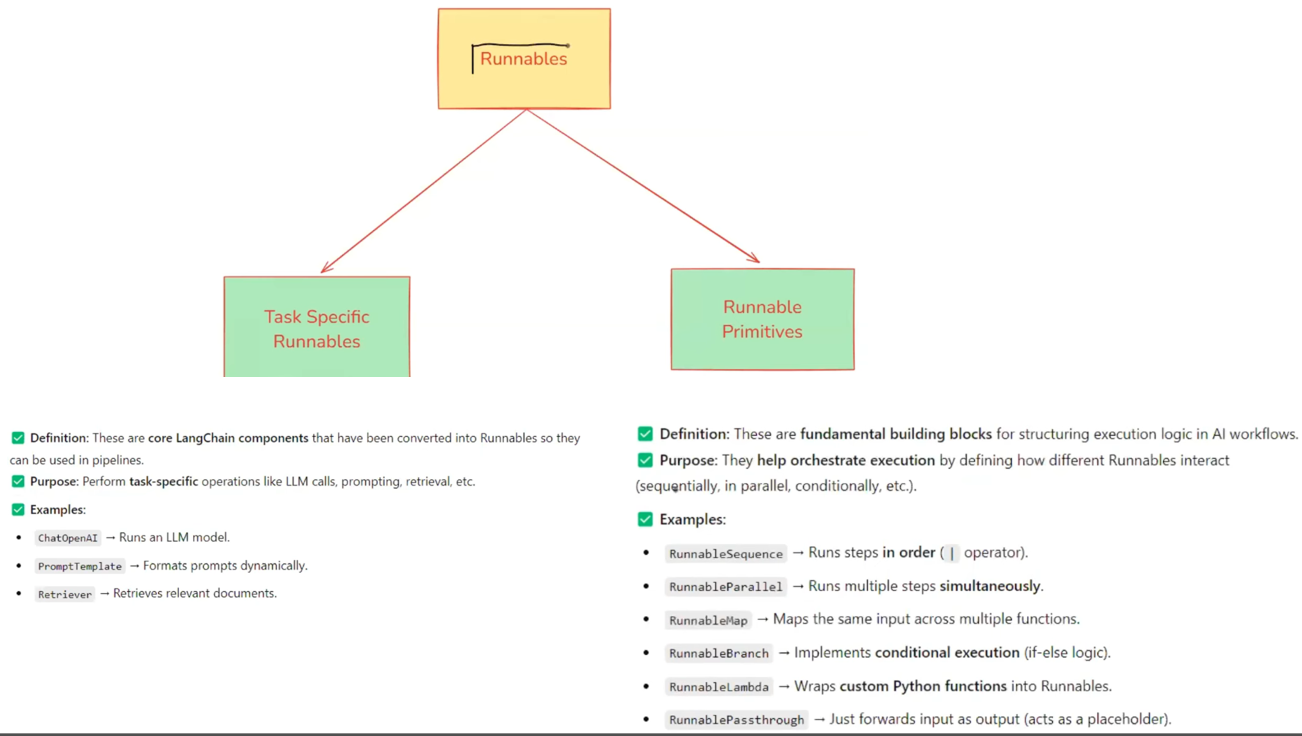

### 🔹 Types of Runnables

Here are the **main runnable types** in LangChain:

1. **RunnableSequence (`|`)**
   
   * RunnableSequence is a sequential chain of runnables in LangChain that executes each step one after another, passing the output of one step as the input to the next. 
   
   * It is useful when you need to compose multiple runnables together in a structured workflow.
   
   * Chains Runnables in sequence (output of one → input of next).
   
   * Example: `prompt | model | parser`.

   ```python
   from langchain_core.prompts import ChatPromptTemplate
   from langchain_openai import ChatOpenAI
   from langchain_core.output_parsers import StrOutputParser

   prompt = ChatPromptTemplate.from_template("Translate to French: {text}")
   model = ChatOpenAI()
   parser = StrOutputParser()

   chain = prompt | model | parser
   print(chain.invoke({"text": "Hello, how are you?"}))
   ```

2. **RunnableParallel**

   * RunnableParallel is a runnable primitive that allows multiple runnables  to execute in parallel. Each runnable receives the same input and processes it independently, producing a dictionary of outputs.

   * Runs multiple Runnables **in parallel** and returns a dict of results.
   
   * Useful for multi-tasking (e.g., summarization + sentiment analysis together).

   ```python
   from langchain.schema.runnable import RunnableParallel

   parallel_chain = RunnableParallel({
       "english": model,
       "french": prompt | model | parser
   })

   print(parallel_chain.invoke("I love pizza!"))
   ```

3. **RunnablePassthrough**
    
   * RunnablePassthroughis a special Runnable primitive that simply returns the input as output without modifying it.
   
   * Just passes the input forward unchanged.
   
   * Useful for debugging or when only some parts of input need modification.

4. **RunnableLambda**
   
   * RunnableLambdais a runnable primitive that allows you to __apply custom Python functions within an AI pipeline__. 
   
   * It acts as a middleware between different AI components, __enabling preprocessing, transformation, API calls,__ filtering, and post-processingin a LangChain workflow.

   * Wraps a simple Python function into a Runnable.
   
   * Useful for custom preprocessing or logic.

   ```python
   from langchain.schema.runnable import RunnableLambda

   to_upper = RunnableLambda(lambda x: x.upper())
   print(to_upper.invoke("hello"))  # "HELLO"
   ```

5. **RunnableBranch**
   
   * RunnableBranchis a control flow componentin LangChain that allows you to conditionally route input data to different chains or runnablesbased on custom logic. 
   
   * It functions __like an if/elif/elseblock for chains__ —where you define a set of condition functions, each associated with a runnable (e.g., LLM call, prompt chain, or tool). 
   
   * The first matching condition is executed. If no condition matches, a default runnableis used (if provided).

   * Lets you create **if/else logic** between Runnables.
   
   * Example: If input length > 20 → summarize, else → translate.

3. **RunnableMap (`+`)**

   * Maps over keys, applying different runnables to different parts of input.
   * Good for **data preprocessing** before sending to models.

7. **RunnableWithFallbacks**

   * Add fallback logic if a Runnable fails.
   * Example: If GPT-4 API fails, fallback to GPT-3.5.

8. **Specialized Runnables (built-in)**

   * `ChatModel`, `LLM`, `Retriever`, `PromptTemplate`, `OutputParser`, etc.
   * All of these are **specific implementations of Runnables**.

---

✅ **In short**:

* **Runnables = Universal computation units in LangChain.**


* They allow **flexible, composable pipelines** for LLM apps.


* Types include `RunnableSequence`, `RunnableParallel`, `RunnableMap`, `RunnableLambda`, `RunnableBranch`, etc.



### Why runnables were needed when we already had chains:

### 🔹 The Problem with **Chains** (Old Approach)

Before `Runnables`, LangChain relied on **Chains**:

* Each `Chain` had a **rigid structure** (e.g., `LLMChain` always = `PromptTemplate → LLM → OutputParser`).
* Extending required **subclassing** (writing new classes).
* No **unified interface** → `LLMChain`, `SequentialChain`, `SimpleSequentialChain`, `RouterChain`, etc. all worked differently.
* Hard to mix-and-match components (e.g., use a retriever in one place, parser in another).
* Asynchronous, streaming, and batch execution were **inconsistent** (different methods per class).

Basically: **Chains were too specific and not composable enough.**

---

### 🔹 Why **Runnables**?

LangChain introduced **Runnables** in **LangChain Expression Language (LCEL)** to solve these problems.

1. **Unification**

   * Instead of dozens of chain classes, **everything is a Runnable** (LLM, Prompt, Parser, Retriever, Tool, etc.).
   * You always interact with them the same way:

     ```python
     runnable.invoke(input)
     runnable.stream(input)
     runnable.batch([inputs])
     ```

2. **Composable Pipelines**

   * With `|` and `+`, you can chain things like Lego blocks.
   * No need to subclass or learn a new chain type.

   ```python
   chain = prompt | model | parser
   ```

3. **Flexibility**

   * Branching (`RunnableBranch`), parallelism (`RunnableParallel`), custom logic (`RunnableLambda`) — all work seamlessly.
   * Chains couldn’t easily handle conditional logic or multi-output.

4. **Consistency Across Execution Modes**

   * Sync (`invoke`), Async (`ainvoke`), Batch (`batch`), Streaming (`stream`) all supported out-of-the-box for any runnable.
   * Old `Chain` classes didn’t have this consistency.

5. **Extensibility**

   * Instead of subclassing, you just compose.
   * Want to add preprocessing? Just insert a `RunnableLambda`.
   * Want to retry on failure? Use `RunnableWithFallbacks`.

### 🔹 Analogy

Think of it like this:

* **Chains (old)** = Pre-built appliances (like a blender or toaster). Useful, but limited.


* **Runnables (new)** = Lego blocks. You can build a blender, a toaster, or even a spaceship 🚀 — because every block has the same connector.



### 🔹 Example: Old vs New

**Old (Chain-based)**

```python
from langchain import LLMChain, OpenAI, PromptTemplate

prompt = PromptTemplate.from_template("Translate: {text}")
llm = OpenAI()
chain = LLMChain(llm=llm, prompt=prompt)

print(chain.run("Hello world"))
```

* Works fine, but rigid. Only does `prompt → LLM`.

---

**New (Runnable-based)**

```python
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

prompt = ChatPromptTemplate.from_template("Translate: {text}")
model = ChatOpenAI()
parser = StrOutputParser()

chain = prompt | model | parser
print(chain.invoke({"text": "Hello world"}))
```

* Flexible — add/remove steps easily.


* Can stream, batch, or async without rewriting.


* Works with any component (retrievers, functions, tools, etc.).



✅ **In short**:

* **Chains were rigid, inconsistent, and hard to extend.**


* **Runnables unify everything under one simple, composable, flexible interface.**


* That’s why LangChain is moving away from "Chains" → toward **LCEL + Runnables** as the core abstraction.


## LCEL -> Langchain Expression Language

**LCEL (LangChain Expression Language)** is a **new way to build pipelines in LangChain**.
Instead of using rigid `Chains`, LCEL uses **Runnables** and simple **operators** (`|`, `+`) to connect components.

Think of LCEL as **a mini DSL (domain-specific language)** for writing LangChain workflows — concise, flexible, and composable.


### NOTE : For sequential chains we can use `|` to connect

### 🔹 Why use LCEL?

* **Simple syntax** → `prompt | model | parser`


* **Composable** → chain, branch, parallelize components like Lego blocks


* **Consistent API** → `.invoke()`, `.batch()`, `.stream()`, `.ainvoke()` work for everything


* **Future-proof** → replaces older chain system

### 🔹 How to Use LCEL

### Example: Prompt → Model → Parser

```python
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

# Step 1: Prompt
prompt = ChatPromptTemplate.from_template("Translate to French: {text}")

# Step 2: Model
model = ChatOpenAI()

# Step 3: Parser
parser = StrOutputParser()

# Build pipeline with LCEL
chain = prompt | model | parser

# Run it
print(chain.invoke({"text": "Hello, how are you?"}))
```

Output:

```
Bonjour, comment ça va ?
```

---

### Other things you can do

* **Parallel execution**

  ```python
  from langchain.schema.runnable import RunnableParallel
  parallel = RunnableParallel({"english": model, "french": chain})
  print(parallel.invoke("I love pizza"))
  ```

* **Batch execution**

  ```python
  chain.batch([{"text": "Hello"}, {"text": "Good morning"}])
  ```

* **Streaming**

  ```python
  for chunk in chain.stream({"text": "Tell me a joke"}):
      print(chunk, end="")
  ```

✅ **In short**:

* **LCEL = LangChain Expression Language** → a new syntax to build workflows using **Runnables**.


* You use it by **connecting components with `|` or `+`** and then calling `.invoke()`, `.batch()`, or `.stream()`.
